In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import datetime
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import gc
import re

In [2]:
train = pd.read_csv('train.csv')
test1 = pd.read_csv('test1.csv')
# labels = train['label']
df_train = train.drop(['Unnamed: 0'], axis=1)
df_test = test1.drop(['Unnamed: 0'], axis=1)

df_test["label"]=-1

for col in ["android_id","apptype","carrier","ntt","media_id","cus_type","package",'fea1_hash',"location"]:
    df_train[col]=df_train[col].astype("object")
    df_test[col]=df_test[col].astype("object")

for col in ["fea_hash"]:
    df_train[col]=df_train[col].map(lambda x:0 if len(str(x))>16 else int(x))
    df_test[col]=df_test[col].map(lambda x:0 if len(str(x))>16 else int(x))

for col in ["dev_height","dev_ppi","dev_width","fea_hash","label"]:
    df_train[col]=df_train[col].astype("int64")
    df_test[col]=df_test[col].astype("int64")

df_test["label"]=None

df_train["truetime"]=pd.to_datetime(df_train['timestamp'],unit='ms',origin=pd.Timestamp('1970-01-01'))
df_test["truetime"]=pd.to_datetime(df_test['timestamp'],unit='ms',origin=pd.Timestamp('1970-01-01'))

df_train["day"]=df_train.truetime.dt.day
df_test["day"]=df_test.truetime.dt.day

df_train["hour"]=df_train.truetime.dt.hour
df_test["hour"]=df_test.truetime.dt.hour

df_train["minute"]=df_train.truetime.dt.minute
df_test["minute"]=df_test.truetime.dt.minute

df_train.set_index("sid",drop=True,inplace=True)
df_test.set_index("sid",drop=True,inplace=True)

In [3]:
df_train.dtypes

android_id            object
apptype               object
carrier               object
dev_height             int64
dev_ppi                int64
dev_width              int64
label                  int64
lan                   object
media_id              object
ntt                   object
os                    object
osv                   object
package               object
timestamp            float64
version               object
fea_hash               int64
location              object
fea1_hash             object
cus_type              object
truetime      datetime64[ns]
day                    int64
hour                   int64
minute                 int64
dtype: object

In [4]:
def summary_stats_table(data):
    '''
    祖传代码：分类型按列的数据分布与异常值统计
    '''
    # 空值数量
    missing_counts = pd.DataFrame(data.isnull().sum())
    missing_counts.columns = ['count_null']

    # 数值列数据分布统计
    num_stats = data.select_dtypes(include=['int64','float64','int32']).describe().loc[['count','min','max','25%','50%','75%']].transpose()
    num_stats['dtype'] = data.select_dtypes(include=['int64','float64','int32']).dtypes.tolist()

    # 非数值列数据分布统计
    non_num_stats = data.select_dtypes(exclude=['int64','float64','int32']).describe().transpose()
    non_num_stats['dtype'] = data.select_dtypes(exclude=['int64','float64','int32']).dtypes.tolist()
    non_num_stats = non_num_stats.rename(columns={"first": "min", "last": "max"})

    # 聚合结果
    stats_merge = pd.concat([num_stats, non_num_stats], axis=0, join='outer', ignore_index=False, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True, sort=False).fillna("").sort_values('dtype')

    column_order = ['dtype', 'count', 'count_null','unique','min','max','25%','50%','75%','top','freq']
    summary_stats = pd.merge(stats_merge, missing_counts, left_index=True, right_index=True, sort=False)[column_order]
    return(summary_stats)
summary_stats_table(df_train)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
dev_height,int64,500000.0,0,,0,9024,720,1280,2040,,
minute,int64,500000.0,0,,0,59,14,29,44,,
hour,int64,500000.0,0,,0,23,5,10,14,,
day,int64,500000.0,0,,2,9,4,6,8,,
fea_hash,int64,500000.0,0,,0,4.29494e+09,1.03451e+09,2.08719e+09,3.17491e+09,,
truetime,datetime64[ns],500000.0,0,500000,2019-06-02 16:00:01.174781250,2019-06-09 16:00:04.317492432,,,,2019-06-08 16:53:01.408521240,1
label,int64,500000.0,0,,0,1,0,0,1,,
dev_width,int64,500000.0,0,,0,8832,360,720,1080,,
dev_ppi,int64,500000.0,0,,0,720,0,0,0,,
timestamp,float64,500000.0,0,,1.55949e+12,1.5601e+12,1.55966e+12,1.55982e+12,1.55996e+12,,


In [5]:
summary_stats_table(df_test)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
dev_height,int64,150000.0,0,,0,8512,720,1280,2038,,
minute,int64,150000.0,0,,0,59,14,29,44,,
hour,int64,150000.0,0,,0,23,5,10,14,,
day,int64,150000.0,0,,2,9,4,6,8,,
truetime,datetime64[ns],150000.0,0,150000,2019-06-02 16:00:03.414976318,2019-06-09 15:59:44.637749512,,,,2019-06-07 00:14:39.307900635,1
dev_width,int64,150000.0,0,,0,9024,360,720,1080,,
dev_ppi,int64,150000.0,0,,0,640,0,0,0,,
fea_hash,int64,150000.0,0,,0,4.29492e+09,1.02766e+09,2.08538e+09,3.18382e+09,,
timestamp,float64,150000.0,0,,1.55949e+12,1.5601e+12,1.55966e+12,1.55982e+12,1.55996e+12,,
cus_type,object,150000.0,0,58,,,,,,411,40239


## 一、类别变量编码与特征工程
### 1.特征apptype label Encoder：对分类型特征值进行编码
发现df_test 中所有的apptype都会被df_train 包括

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df_train.apptype=le.fit_transform(df_train.apptype)
df_train["apptype"]=df_train["apptype"].astype("object")

df_test.apptype=le.transform(df_test.apptype)
df_test["apptype"]=df_test["apptype"].astype("object")

### 2.特征carrier label Encoder：对分类型特征值进行编码
设备使用的运营商 0-未知, 46000-移动, 46001-联通, 46003-电信,-1当成未知

In [7]:
dict1={0.0:0, 46000.0:1, 46001.0:2, 46003.0:3,-1.0:-1}
df_train.carrier=df_train.carrier.map(dict1)
df_train["carrier"]=df_train["carrier"].astype("object")

df_test.carrier=df_test.carrier.map(dict1)
df_test["carrier"]=df_test["carrier"].astype("object")

### 10.media_id:媒体信息，对外媒体ID

test 与train 非对应

非对应的id最高出现不超过10次(head200)

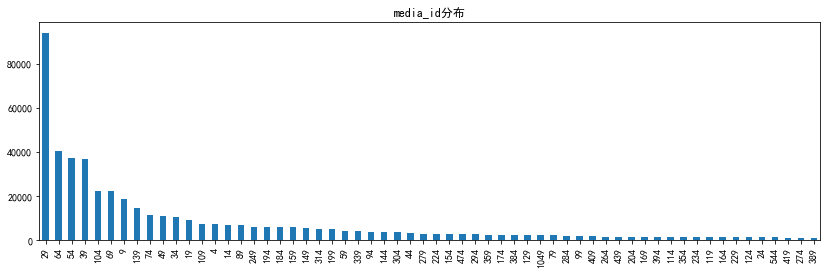

In [8]:
plt.figure(figsize=(14,4))
plt.title('media_id分布')
df_train["media_id"].value_counts().head(60).plot(kind="bar");

In [9]:
def cross_col(col):
    atrd=[]
    ated=[]
    for num in df_test[col].unique():
        if num not in df_train[col].unique():
            ated.append(num)
    for num in df_train[col].unique():
        if num not in df_test[col].unique():
            atrd.append(num)
    print("只存在test里:",ated)
    print("只存在train里:",atrd) 
cross_col("media_id")

只存在test里: [1124, 1504, 1474, 979, 1484, 1534, 1539, 1444]
只存在train里: [1044, 1284, 1404, 1184, 1349, 1289, 1314, 1329, 939, 784, 1129, 994, 1394, 1414, 1489, 1269, 1389, 1229, 1139, 1214, 1324, 1189, 1439, 1204, 1529, 1254, 1449, 969, 1099, 1319, 1429, 1434, 619, 1424, 1379, 984, 1104, 959, 1544, 989, 1499, 1199, 1239, 1219]


In [10]:
set2=set(df_train["media_id"].value_counts().head(200).index)
def process_media_id(x):
    if x in set2:
        return x
    else:
        return -1

df_train["media_id"]=df_train["media_id"].apply(process_media_id)
df_test["media_id"]=df_test["media_id"].apply(process_media_id)

from sklearn import preprocessing
le5 = preprocessing.LabelEncoder()

df_train.media_id=le5.fit_transform(df_train.media_id)
df_train["media_id"]=df_train["media_id"].astype("object")

df_test.media_id=le5.transform(df_test.media_id)
df_test["media_id"]=df_test["media_id"].astype("object")

cross_col("media_id")

只存在test里: []
只存在train里: [151, 195]


### 11.ntt:网络类型 0-未知, 1-有线网, 2-WIFI, 3-蜂窝网络未知, 4-2G, 5-3G, 6–4G

In [11]:
from sklearn import preprocessing
le6 = preprocessing.LabelEncoder()

df_train.ntt=le6.fit_transform(df_train.ntt)
df_train["ntt"]=df_train["ntt"].astype("object")

df_test.ntt=le6.transform(df_test.ntt)
df_test["ntt"]=df_test["ntt"].astype("object")

cross_col("ntt")

只存在test里: []
只存在train里: [1]


### 3.dev_height	:设备高   dev_width:设备宽
0的数据过多(1/5)，还原成Nan的，不是整数的数据都是少数

### 4.dev_ppi:屏幕分辨率
0还是多(4/5)

In [12]:
df_train.dev_height[df_train.dev_height==0]=None
df_train.dev_width[df_train.dev_width==0]=None
df_train.dev_ppi[df_train.dev_ppi==0]=None
df_test.dev_height[df_test.dev_height==0]=None
df_test.dev_width[df_test.dev_width==0]=None
df_test.dev_ppi[df_test.dev_ppi==0]=None

### 4.1 RF 预测dev_ppi

In [13]:
gc.collect()
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

c1=df_train.dev_width.notnull()
c2=df_train.dev_height.notnull()
c3=df_train.dev_ppi.isna()
c4=df_train.dev_ppi.notnull()
df_train["mynull1"]=c1&c2&c3
df_train["mynull2"]=c1&c2&c4

predict=df_train[["apptype","carrier","dev_height","dev_ppi","dev_width","media_id","ntt","mynull1","mynull2"]]

df_notnans = predict[predict.mynull2==True]

# Split into 75% train and 25% test
X_train, X_test, y_train, y_test = train_test_split(df_notnans[["apptype","carrier","dev_height","dev_width","media_id","ntt"]], df_notnans["dev_ppi"],train_size=0.75, random_state=6)

regr_multirf = RandomForestClassifier(n_estimators=100,max_depth=40, random_state=0,n_jobs=-1)

# Fit on the train data
regr_multirf.fit(X_train, y_train)

# Check the prediction score
score = regr_multirf.score(X_test, y_test)
print("The prediction score on the test data is {:.2f}%".format(score*100))

The prediction score on the test data is 97.38%


In [30]:
df_nans = predict[predict.mynull1==True].copy()
df_nans["dev_ppi_pred"] = regr_multirf.predict(df_nans[["apptype","carrier","dev_height","dev_width","media_id","ntt"]])
df_nans

,apptype,carrier,dev_height,dev_ppi,dev_width,media_id,ntt,mynull1,mynull2,dev_ppi_pred
sid,,,,,,,,,,
1555716,22,0,760.0,NaN,360.0,111,0,True,False,2.0
1093419,49,1,2214.0,NaN,1080.0,26,2,True,False,480.0
1400089,62,1,2280.0,NaN,1080.0,13,2,True,False,480.0
1597216,48,1,760.0,NaN,360.0,6,2,True,False,1.0
1785622,48,1,760.0,NaN,360.0,6,2,True,False,1.0
...,...,...,...,...,...,...,...,...,...,...
1472150,12,3,1920.0,NaN,1080.0,11,6,True,False,3.0
1555117,12,1,1920.0,NaN,1080.0,11,2,True,False,3.0
1480612,48,0,1424.0,NaN,720.0,6,2,True,False,2.0


In [28]:
df_train=pd.merge(df_train,df_nans["dev_ppi_pred"],on="sid",how="left")

,android_id,apptype,carrier,dev_height,dev_ppi_x,dev_width,label,lan,media_id,ntt,...,location,fea1_hash,cus_type,truetime,day,hour,minute,mynull1,mynull2,dev_ppi_y
sid,,,,,,,,,,,,,,,,,,,,,
1438873,316361,81,1,NaN,NaN,NaN,1,NaN,21,6,...,0,2329670524,601,2019-06-07 07:32:08.241721191,7,7,32,False,False,NaN
1185582,135939,31,0,NaN,NaN,NaN,1,NaN,4,6,...,1,2864801071,1000,2019-06-08 11:40:20.922228760,8,11,40,False,False,NaN
1555716,399254,22,0,760.0,NaN,360.0,1,NaN,111,0,...,2,628911675,696,2019-06-06 15:58:17.549108643,6,15,58,True,False,2.0
1093419,68983,49,1,2214.0,NaN,1080.0,0,NaN,26,2,...,3,1283809327,753,2019-06-09 00:59:37.719684814,9,0,59,True,False,480.0
1400089,288999,62,1,2280.0,NaN,1080.0,1,zh-CN,13,2,...,4,1510695983,582,2019-06-07 00:28:21.478552734,7,0,28,True,False,480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546078,392477,53,1,1920.0,3.0,1080.0,1,zh-CN,29,6,...,79,140647032,373,2019-06-06 15:14:18.267241699,6,15,14,False,True,NaN
1480612,346134,48,0,1424.0,NaN,720.0,0,NaN,6,2,...,23,2745131047,525,2019-06-06 09:40:54.045280518,6,9,40,True,False,2.0
1698442,499635,12,1,1280.0,NaN,720.0,0,NaN,11,6,...,25,1326115882,810,2019-06-04 19:14:57.290064453,4,19,14,True,False,320.0


### 5.构造新特征：能否被160整除 // 高宽比 // 根据ppi公式反推inch

In [9]:
def divided(x):
    if x%10==0:
        return 2
    elif not x:
        return 1
    else:
        return 0

df_train["160_height"]=df_train.dev_height.apply(divided)
df_test["160_height"]=df_test.dev_height.apply(divided)
df_train["160_width"]=df_train.dev_width.apply(divided)
df_test["160_width"]=df_test.dev_width.apply(divided)
df_train["160_ppi"]=df_train.dev_height.apply(divided)
df_test["160_ppi"]=df_test.dev_height.apply(divided)

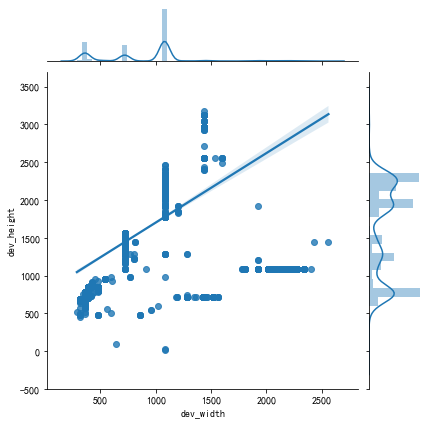

In [61]:
sns.jointplot(x="dev_width",y="dev_height",data=df_train[:10000],kind="reg");

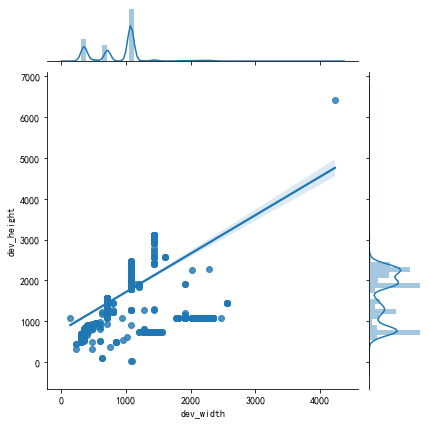

In [62]:
sns.jointplot(x="dev_width",y="dev_height",data=df_test[:10000],kind="reg");

In [63]:
df_train["hw_ratio"]=df_train.dev_height/df_train.dev_width
df_test["hw_ratio"]=df_test.dev_height/df_test.dev_width

In [64]:
df_train["inch"]=(df_train.dev_height**2+df_train.dev_width**2)**0.5/df_train.dev_ppi
df_test["inch"]=(df_test.dev_height**2+df_test.dev_width**2)**0.5/df_test.dev_ppi

In [65]:
df_train.head(20)

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,...,cus_type,truetime,day,hour,minute,160_height,160_width,160_ppi,hw_ratio,inch
sid,,,,,,,,,,,,,,,,,,,,,
1438873,316361,81,1,NaN,NaN,NaN,1,NaN,104,6,...,601,2019-06-07 07:32:08.241721191,7,7,32,0,0,0,NaN,NaN
1185582,135939,31,0,NaN,NaN,NaN,1,NaN,19,6,...,1000,2019-06-08 11:40:20.922228760,8,11,40,0,0,0,NaN,NaN
1555716,399254,22,0,760.0,NaN,360.0,1,NaN,559,0,...,696,2019-06-06 15:58:17.549108643,6,15,58,0,0,0,2.111111,NaN
1093419,68983,49,1,2214.0,NaN,1080.0,0,NaN,129,2,...,753,2019-06-09 00:59:37.719684814,9,0,59,0,0,0,2.050000,NaN
1400089,288999,62,1,2280.0,NaN,1080.0,1,zh-CN,64,2,...,582,2019-06-07 00:28:21.478552734,7,0,28,0,0,0,2.111111,NaN
1253737,184658,18,1,2196.0,480.0,1080.0,1,zh-CN,194,6,...,430,2019-06-08 06:34:10.366265869,8,6,34,0,0,0,2.033333,5.098345
1387136,0,68,1,NaN,NaN,NaN,0,NaN,39,0,...,411,2019-06-06 18:12:48.395789062,6,18,12,0,0,0,NaN,NaN
1597216,0,48,1,760.0,NaN,360.0,1,zh-CN,29,2,...,411,2019-06-06 01:02:11.781200928,6,1,2,0,0,0,2.111111,NaN
1910989,646994,31,0,NaN,NaN,NaN,0,NaN,19,6,...,886,2019-06-03 08:01:24.868135254,3,8,1,0,0,0,NaN,NaN


### 7.location:地理位置

In [66]:
from sklearn import preprocessing
le2 = preprocessing.LabelEncoder()

df_train.location=le2.fit_transform(df_train.location)
df_train["location"]=df_train["location"].astype("object")

df_test.location=le2.transform(df_test.location)
df_test["location"]=df_test["location"].astype("object")

### 8.version:

In [67]:
df_test.version=df_test.version.replace("20","0")

le3 = preprocessing.LabelEncoder()

df_train.version=le3.fit_transform(df_train.version)
df_train["version"]=df_train["version"].astype("object")

df_test.version=le3.transform(df_test.version)
df_test["version"]=df_test["version"].astype("object")

### 9.lan

train 和test 的标志不一致

只规划大于10个的标志，其余的规划为UNK(包括Nan)

In [68]:
def process_lan(x):
    set1=set(['zh-CN', 'zh', 'cn', 'zh_CN', 'Zh-CN', 'zh-cn', 'ZH', 'CN', 'tw', 'en','zh_CN_#Hans', 'ko'])
    if x in set1:
        return x
    else:
        return "unk"

In [69]:
df_train["lan"]=df_train["lan"].apply(process_lan)
df_test["lan"]=df_test["lan"].apply(process_lan)

from sklearn import preprocessing
le4 = preprocessing.LabelEncoder()

df_train.lan=le4.fit_transform(df_train.lan)
df_train["lan"]=df_train["lan"].astype("object")

df_test.lan=le4.transform(df_test.lan)
df_test["lan"]=df_test["lan"].astype("object")

### 12.os

In [78]:
from sklearn import preprocessing
le7 = preprocessing.LabelEncoder()

df_train.os=le7.fit_transform(df_train.os)
df_train["os"]=df_train["os"].astype("object")

df_test.os=le7.transform(df_test.os)
df_test["os"]=df_test["os"].astype("object")

### 13.osv:
这版本也太多了把，用正则表达式匹配数字

这里用粗略匹配，用第一个数字表示版本，转换成为int64

In [79]:
def process_osv(x):
    x=str(x)
    if not x:
        return -1
    elif x.startswith("Android"):
        x=str(re.findall("\d{1}\.*\d*\.*\d*",x)[0])
        return x
    elif x.isdigit():
        return x
    else:
        try:
            x=str(re.findall("\d{1}\.\d\.*\d*",x)[0])
            return x
        except:
            return 0

In [80]:
df_train.osv=df_train.osv.apply(process_osv)
df_test.osv=df_test.osv.apply(process_osv)

In [81]:
set3=set(df_train["osv"].value_counts().index)
def process_osv(x):
    if x in set3:
        return x
    else:
        return 0

In [82]:
# df_train["osv"]=df_train["osv"].apply(process_osv)
df_test["osv"]=df_test["osv"].apply(process_osv)

In [83]:
cross_col("osv")

只存在test里: []
只存在train里: ['9.1', '7910', '0.3.3', '2.3.6', '2.3.5', '5.12', '6.0.2', '4.3.1', '2.3.7', '71200', '4', '8.0.2', '9.1.0', '5.3', '4.2.9', '7920', '5.0.3', '2.9.2', '2.2.2']


In [84]:
from sklearn import preprocessing
le8 = preprocessing.LabelEncoder()

df_train.osv=le8.fit_transform(df_train.osv.astype("str"))
df_train["osv"]=df_train["osv"].astype("object")

df_test.osv=le8.transform(df_test.osv.astype("str"))
df_test["osv"]=df_test["osv"].astype("object")

14.package:媒体信息，包名（已加密）

In [85]:
set3=set(df_train.package.value_counts().head(800).index)
def process_package(x):
    if x in set3:
        return x
    else:
        return -1

In [86]:
df_train.package=df_train.package.apply(process_package)
df_test.package=df_test.package.apply(process_package)

In [87]:
cross_col("package")
gc.collect()

只存在test里: []
只存在train里: [691, 1625, 801, 713, 576, 1525, 1263, 553, 882, 455, 839, 1535, 1405, 1674, 1049, 1202, 994, 1691, 1318, 588, 771, 1081, 596, 938, 320, 607, 1019, 640, 494, 707, 1160, 559, 328, 612, 1091, 1005, 915, 901, 772, 905, 788, 1067, 1166, 1584, 103, 1681, 1761, 1449, 165, 858, 144, 761, 210, 1567, 1044, 899, 239, 648, 918, 1200, 698, 704, 481, 1718, 487, 647, 400, 1475, 544, 369, 405, 1024, 1120]


9370

In [88]:
from sklearn import preprocessing
le18 = preprocessing.LabelEncoder()

df_train.package=le18.fit_transform(df_train.package)
df_train["package"]=df_train["package"].astype("object")

df_test.package=le18.transform(df_test.package)
df_test["package"]=df_test["package"].astype("object")

### 15.fea_hash:int64

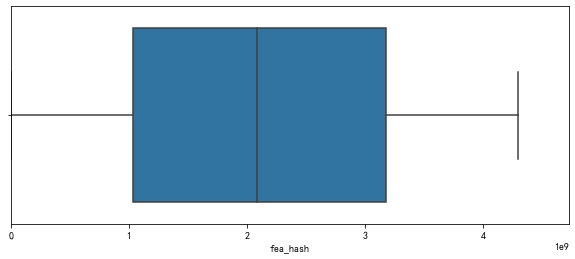

In [89]:
plt.figure(figsize=(10,4))
# x轴坐标范围
plt.xlim(df_train.fea_hash.min(), df_train.fea_hash.max()*1.1)
sns.boxplot(x=df_train.fea_hash)
plt.show()

### 16.fea1_hash

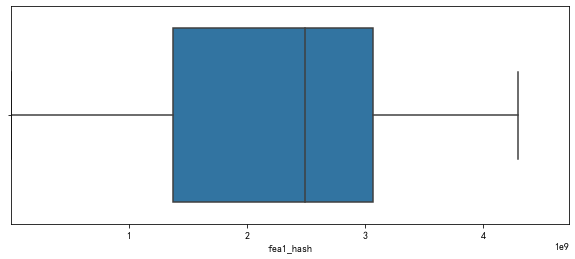

In [90]:
plt.figure(figsize=(10,4))
# x轴坐标范围
plt.xlim(df_train.fea1_hash.min(), df_train.fea1_hash.max()*1.1)
sns.boxplot(x=df_train.fea1_hash)
plt.show()

In [91]:
set4=set(df_train.fea1_hash.value_counts().head(850).index)
def process_fea1_hash(x):
    if x in set4:
        return x
    else:
        return -1

In [92]:
df_train.fea1_hash=df_train.fea1_hash.apply(process_fea1_hash)
df_test.fea1_hash=df_test.fea1_hash.apply(process_fea1_hash)

In [93]:
from sklearn import preprocessing
le9 = preprocessing.LabelEncoder()

df_train.fea1_hash=le9.fit_transform(df_train.fea1_hash)
df_train["fea1_hash"]=df_train["fea1_hash"].astype("object")

df_test.fea1_hash=le9.transform(df_test.fea1_hash)
df_test["fea1_hash"]=df_test["fea1_hash"].astype("object")

### 17.cus_type

In [94]:
from sklearn import preprocessing
le10 = preprocessing.LabelEncoder()

df_train.cus_type=le10.fit_transform(df_train.cus_type)
df_train["cus_type"]=df_train["cus_type"].astype("object")

df_test.cus_type=le10.transform(df_test.cus_type)
df_test["cus_type"]=df_test["cus_type"].astype("object")

### 18.android_id

In [45]:
# set4=set(df_train.android_id.value_counts().head(8164).index)
# def process_android_id_train(x):
#     if x in set4:
#         return x
#     else:
#         return -1

In [46]:
# df_train.android_id=df_train.android_id.apply(process_android_id_train)
# df_test.android_id=df_test.android_id.apply(process_android_id_train)

In [48]:
# le11 = preprocessing.LabelEncoder()

# df_train.android_id=le11.fit_transform(df_train.android_id)
# df_train["android_id"]=df_train["android_id"].astype("object")

# df_test.android_id=le11.transform(df_test.android_id)
# df_test["android_id"]=df_test["android_id"].astype("object")

### summary

In [95]:
summary_stats_table(df_train)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
160_ppi,int64,500000.0,0,,0,2,0,0,0,,
label,int64,500000.0,0,,0,1,0,0,1,,
160_width,int64,500000.0,0,,0,2,0,0,0,,
fea_hash,int64,500000.0,0,,0,4.29494e+09,1.03451e+09,2.08719e+09,3.17491e+09,,
day,int64,500000.0,0,,2,9,4,6,8,,
hour,int64,500000.0,0,,0,23,5,10,14,,
minute,int64,500000.0,0,,0,59,14,29,44,,
160_height,int64,500000.0,0,,0,2,0,0,0,,
dev_height,float64,392986.0,107014,,7,9024,960,1920,2160,,
hw_ratio,float64,392986.0,107014,,0.00350877,3.75,1.77778,1.99444,2.11111,,


In [96]:
summary_stats_table(df_test)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
160_ppi,int64,150000.0,0,,0,2,0,0,0,,
160_width,int64,150000.0,0,,0,2,0,0,0,,
160_height,int64,150000.0,0,,0,2,0,0,0,,
minute,int64,150000.0,0,,0,59,14,29,44,,
dev_height,float64,117801.0,32199,,1,8512,960,1920,2160,,
inch,float64,34473.0,115527,,0.942809,3321.22,4.58939,5.23149,734.302,,
hw_ratio,float64,117801.0,32199,,0.00138889,7.2,1.77778,1.99444,2.11111,,
truetime,datetime64[ns],150000.0,0,150000,2019-06-02 16:00:03.414976318,2019-06-09 15:59:44.637749512,,,,2019-06-07 00:14:39.307900635,1
day,int64,150000.0,0,,2,9,4,6,8,,
fea_hash,int64,150000.0,0,,0,4.29492e+09,1.02766e+09,2.08538e+09,3.18382e+09,,


In [97]:
df_train.to_pickle("./processed_data/df_train2.pkl")
df_test.to_pickle("./processed_data/df_test2.pkl")